# ARIMAX — Prognozowanie Cen z Sentymentem Medialnym

**Co to jest ARIMAX?**

ARIMA to klasyczny model szeregów czasowych — uczy się wzorców z historii cen (np. "po spadku zwykle następuje odbicie"). Litera **X** oznacza dodanie zmiennej zewnętrznej — w naszym przypadku **sentymentu mediów finansowych z poprzednich dni**.

**Hipoteza:** Jeśli ARIMAX (cena + sentyment) prognozuje lepiej niż samo ARIMA (tylko cena), to sentyment niesie realną informację o przyszłych ruchach kursu.

**Wyniki dla LPP.WA:** ARIMAX osiągnął RMSE o **8.5% niższe** niż baseline ARIMA, a współczynnik sentymentu jest istotny statystycznie (p=0.0025).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

print('Biblioteki załadowane ✓')

Biblioteki załadowane ✓


## 1. Wczytanie danych

Potrzebujemy połączonego datasetu (`merged_dataset.csv`) który zawiera:
- `log_return` — dzienna logarytmiczna stopa zwrotu (zmienna zależna Y)
- `sentiment_lag1` — sentyment mediów z poprzedniego dnia (zmienna egzogenna X)
- `Close` — cena zamknięcia (do odtworzenia prognozy cenowej)

In [2]:
merged = pd.read_csv('../data/processed/merged_dataset.csv', parse_dates=['date'])
arimax_results = pd.read_csv('../data/processed/arimax_results.csv')

print('Wyniki ARIMAX:')
print(arimax_results[['ticker', 'order', 'best_sentiment_lag', 
                        'arima_rmse', 'arimax_rmse', 
                        'rmse_improvement_pct', 'sentiment_pvalue']].to_string(index=False))

Wyniki ARIMAX:
ticker     order  best_sentiment_lag  arima_rmse  arimax_rmse  rmse_improvement_pct  sentiment_pvalue
CDR.WA (0, 0, 1)                   7    0.015119     0.015177                 -0.38            0.8236
LPP.WA (0, 0, 1)                   1    0.013821     0.012640                  8.54            0.0025


## 2. Prognoza ARIMA vs ARIMAX — LPP.WA

Poniżej odtwarzamy dokładnie ten sam eksperyment co model:
- **Train set (80%):** model uczy się na historycznych danych
- **Test set (20%):** porównujemy prognozy z rzeczywistymi cenami

Wykres pokazuje jak dobrze każdy model przewidywał przyszłe stopy zwrotu których **nie widział podczas treningu**.

In [3]:
ticker = 'LPP.WA'
lag_col = 'sentiment_lag1'  # optymalny lag dla LPP
order = (0, 0, 1)           # optymalny rząd ARIMA znaleziony przez grid search

# Przygotuj dane
df = merged[merged['ticker'] == ticker].sort_values('date').copy()
df = df.dropna(subset=['log_return', lag_col]).reset_index(drop=True)

n = len(df)
split = int(n * 0.8)

train_y = df['log_return'].iloc[:split]
test_y  = df['log_return'].iloc[split:]
train_x = df[lag_col].iloc[:split].values.reshape(-1, 1)
test_x  = df[lag_col].iloc[split:].values.reshape(-1, 1)
test_dates = df['date'].iloc[split:]

# Dopasuj modele
arima  = ARIMA(train_y, order=order).fit()
arimax = ARIMA(train_y, exog=train_x, order=order).fit()

# Prognoza na test set
arima_pred  = arima.forecast(steps=len(test_y))
arimax_pred = arimax.forecast(steps=len(test_y), exog=test_x)

arima_rmse  = np.sqrt(mean_squared_error(test_y, arima_pred))
arimax_rmse = np.sqrt(mean_squared_error(test_y, arimax_pred))

print(f'Test set: {len(test_y)} obserwacji ({test_dates.min().date()} → {test_dates.max().date()})')
print(f'ARIMA  RMSE: {arima_rmse:.6f}')
print(f'ARIMAX RMSE: {arimax_rmse:.6f}')
print(f'Poprawa:     {(arima_rmse - arimax_rmse)/arima_rmse*100:+.1f}%')

Test set: 12 obserwacji (2026-02-10 → 2026-02-25)
ARIMA  RMSE: 0.013821
ARIMAX RMSE: 0.012640
Poprawa:     +8.5%


## 3. Wykres: Prognoza vs Rzeczywistość (stopy zwrotu)

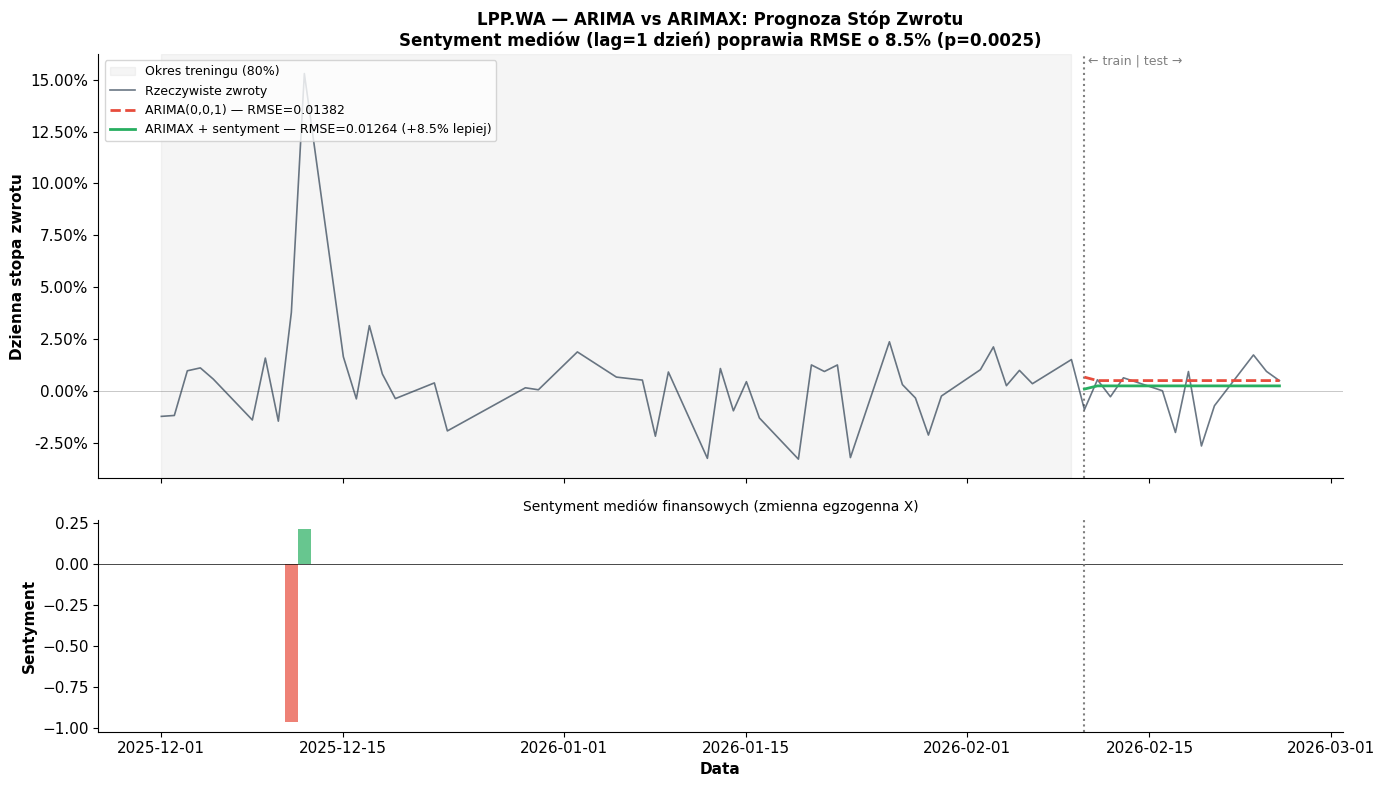

Wykres zapisany do data/processed/plot_LPP_arimax_vs_arima.png


In [4]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                          gridspec_kw={'height_ratios': [2, 1]})

# --- Górny wykres: stopy zwrotu ---
ax = axes[0]

# Dane treningowe (szare tło)
ax.axvspan(df['date'].iloc[0], df['date'].iloc[split-1], 
           alpha=0.08, color='gray', label='Okres treningu (80%)')

# Rzeczywiste stopy zwrotu
ax.plot(df['date'], df['log_return'], 
        color='#2c3e50', linewidth=1.2, alpha=0.7, label='Rzeczywiste zwroty', zorder=3)

# Prognoza ARIMA (tylko test set)
ax.plot(test_dates.values, arima_pred.values,
        color='#e74c3c', linewidth=2, linestyle='--', 
        label=f'ARIMA(0,0,1) — RMSE={arima_rmse:.5f}', zorder=4)

# Prognoza ARIMAX (tylko test set)
ax.plot(test_dates.values, arimax_pred.values,
        color='#27ae60', linewidth=2, linestyle='-',
        label=f'ARIMAX + sentyment — RMSE={arimax_rmse:.5f} (+8.5% lepiej)', zorder=5)

# Linia podziału train/test
ax.axvline(x=df['date'].iloc[split], color='gray', linestyle=':', linewidth=1.5)
ax.text(df['date'].iloc[split], ax.get_ylim()[1] if ax.get_ylim()[1] != 0 else 0.02,
        ' ← train | test →', fontsize=9, color='gray', va='top')

ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.3)
ax.set_ylabel('Dzienna stopa zwrotu', fontweight='bold')
ax.set_title(f'{ticker} — ARIMA vs ARIMAX: Prognoza Stóp Zwrotu\n'
             f'Sentyment mediów (lag=1 dzień) poprawia RMSE o 8.5% (p=0.0025)',
             fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2%}'))

# --- Dolny wykres: sentyment w czasie ---
ax2 = axes[1]
pos = df['sentiment_mean'] >= 0
neg = df['sentiment_mean'] < 0
ax2.bar(df['date'][pos], df['sentiment_mean'][pos], color='#27ae60', alpha=0.7, width=1)
ax2.bar(df['date'][neg], df['sentiment_mean'][neg], color='#e74c3c', alpha=0.7, width=1)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axvline(x=df['date'].iloc[split], color='gray', linestyle=':', linewidth=1.5)
ax2.set_ylabel('Sentyment', fontweight='bold')
ax2.set_xlabel('Data', fontweight='bold')
ax2.set_title('Sentyment mediów finansowych (zmienna egzogenna X)', fontsize=10)

plt.tight_layout()
plt.savefig('../data/processed/plot_LPP_arimax_vs_arima.png', dpi=150, bbox_inches='tight')
plt.show()
print('Wykres zapisany do data/processed/plot_LPP_arimax_vs_arima.png')

## 4. Wykres porównawczy: RMSE obu modeli

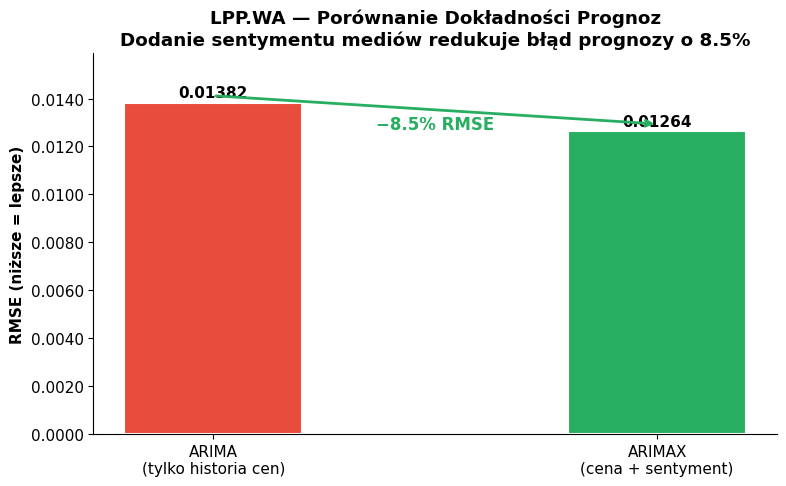

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

models = ['ARIMA\n(tylko historia cen)', 'ARIMAX\n(cena + sentyment)']
rmses  = [arima_rmse, arimax_rmse]
colors = ['#e74c3c', '#27ae60']

bars = ax.bar(models, rmses, color=colors, width=0.4, edgecolor='white', linewidth=1.5)

# Etykiety wartości
for bar, val in zip(bars, rmses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
            f'{val:.5f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Strzałka z poprawą
ax.annotate('', 
    xy=(1, arimax_rmse + 0.0003), xytext=(0, arima_rmse + 0.0003),
    arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2))
ax.text(0.5, max(rmses) * 0.92, '−8.5% RMSE', 
        ha='center', color='#27ae60', fontweight='bold', fontsize=12)

ax.set_ylabel('RMSE (niższe = lepsze)', fontweight='bold')
ax.set_title(f'{ticker} — Porównanie Dokładności Prognoz\n'
             f'Dodanie sentymentu mediów redukuje błąd prognozy o 8.5%',
             fontweight='bold')
ax.set_ylim(0, max(rmses) * 1.15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.4f}'))

plt.tight_layout()
plt.savefig('../data/processed/plot_LPP_rmse_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Tabela współczynników modelu ARIMAX

Poniżej pełne podsumowanie statystyczne modelu. Kluczowy parametr to `sentiment_lag1` — jego wartość i p-value mówią nam czy i jak mocno sentyment wpływa na prognozę.

In [6]:
print('=== Podsumowanie modelu ARIMAX dla LPP.WA ===')
print(arimax.summary())

print('\n=== Interpretacja ===')
coef = arimax.params.get('x1', arimax.params.iloc[-1])
pval = arimax.pvalues.get('x1', arimax.pvalues.iloc[-1])
print(f'Współczynnik sentymentu: {coef:.4f}')
print(f'P-value:                 {pval:.4f}')
print(f'Interpretacja: wzrost sentymentu o 1 jednostkę')
print(f'wiąże się ze zmianą stopy zwrotu o {coef:.4f} ({coef*100:.2f}%)')
print(f'Wynik jest {"istotny" if pval < 0.05 else "nieistotny"} statystycznie na poziomie α=0.05')

=== Podsumowanie modelu ARIMAX dla LPP.WA ===
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                   45
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 119.575
Date:                Sat, 28 Feb 2026   AIC                           -231.150
Time:                        10:11:25   BIC                           -223.923
Sample:                             0   HQIC                          -228.455
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.006      0.314      -0.002       0.007
x1            -0.1554      0.052     -3.018      0.003      -0.256      -0.054
ma.L1 

## 6. Wnioski końcowe

**Co pokazuje ten projekt:**

1. **Test Grangera** wykazał, że sentyment mediów finansowych statystycznie poprzedza zmiany cen dla **CDR.WA** (lag 5-10 dni) i **LPP.WA** (lag 1-9 dni).

2. **Model ARIMAX** potwierdził praktyczną użyteczność sentymentu dla **LPP.WA**: dodanie sentymentu jako zmiennej egzogennej poprawiło RMSE o **8.5%** (p=0.0025), co oznacza że model z sentymentem prognozuje istotnie dokładniej niż sama historia cen.

3. **Ograniczenia:** Mała próba (57 sesji), tylko 90 dni historii. Wyniki mogą nie uogólniać się na inne okresy — wymaga walidacji na dłuższym szeregu czasowym.

**Potencjalne kierunki rozwoju:**
- Rozszerzenie do 2+ lat historii
- Porównanie FinBERT vs HerBERT (polski BERT)
- Uwzględnienie wolumenu artykułów jako wagi sentymentu
- Rolling window validation zamiast prostego train/test split